In [ ]:
import numpy as np
import pandas as pd
import spacy
import random
import torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from gensim.models import word2vec
import matplotlib.pyplot as plt

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
   
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1l1WBEb2GvJo8fXALiDwNrdy9RkM30EVL'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_x.csv')
file_id = '14dHld_a7dQg_uFh9uMAu-8qKEsV_aL8u'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_y.csv')
file_id = '1IjLU8q60yWbrJyw5mEwasjfkCL2NhEAS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_x.csv')

In [ ]:
trainX = pd.read_csv('train_x.csv')
trainY = pd.read_csv('train_y.csv')
testX = pd.read_csv('test_x.csv')

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 95.4MB 3.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126237 sha256=fc19f62b3c4d1ec12fabe1269c2f41189f2514aef1e5f5aea07f692c4ea5fd5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vron2ywu/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()
tokenizer = spacy.lang.en.English().Defaults().create_tokenizer(nlp)

In [ ]:
def read_data(x,train=False):
    vec = 100
    stopword = [',','.']
    for i in stopword:
        x['comment'] = x['comment'].map(lambda x : x.replace(i,''))
    ptt = []
    for i in x['comment'].values:
        ptt.append(nlp(i)) 
    ptt_remove_stop = []
    for doc in ptt:
        ptt_remove_stop.append([token.lemma_ for token in doc if not token.is_stop])
    if train:    
        model_w2v = word2vec.Word2Vec(ptt_remove_stop, size = vec)    
        w2v = []
        for _, key in enumerate(model_w2v.wv.vocab):
            w2v.append((key, model_w2v.wv[key]))
        special_tokens = ["<PAD>", "<UNK>"]
        for token in special_tokens:
            w2v.append((token, [0.0] * vec)) 
        return  w2v,ptt_remove_stop
    else:
      return ptt_remove_stop   

In [ ]:
class Vocab:
    def __init__(self, w2v, data):
        self.w2v = w2v
        self.data = data
        self._idx2token = [token for token, _ in w2v]
        self._token2idx = {token: idx for idx,
                           token in enumerate(self._idx2token)}
        self.PAD, self.UNK = self._token2idx["<PAD>"], self._token2idx["<UNK>"]

    def trim_pad(self, tokens, seq_len):
        return tokens[:min(seq_len, len(tokens))] + [self.PAD] * (seq_len - len(tokens))

    def convert_tokens_to_indices(self, tokens):
        return [
            self._token2idx[token]
            if token in self._token2idx else self.UNK
            for token in tokens]
    
    def data2v(self, idx):
        indx = self.convert_tokens_to_indices(self.data[idx])
        indx = self.trim_pad(indx, 30)
        indx = [self.w2v[token][1] for token in indx]
        return np.array(indx)
    
    def data2v2(self):
        indx = np.zeros((len(self.data),30,100))
        for i in range(len(self.data)):
            indx[i] = self.data2v(i)
        return indx

    def __len__(self):
        return len(self._idx2token)

In [ ]:
class LSTM_dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

        
    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        vec = self.data[idx][0]
        vec = self.transform(vec)
        label = self.data[idx][1]
        return vec, label

In [ ]:
class LSTM_Net(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, bidirectional, dropout):
        super(LSTM_Net, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size * (1+bidirectional), 1),
            nn.Sigmoid()
 )

    def forward(self, batch):
        #batch = self.embedding(batch)
        output, (_, _) = self.rnn(batch)
        output = output.mean(1)
        logit = self.classifier(output)
        return logit

In [ ]:
from sklearn.metrics import f1_score
def evaluation(output, labels):
    output[output >=0.5 ] = 1
    output[output < 0.5 ] = 0
    output = output.cpu()
    output = output.detach().numpy()
    labels = labels.cpu()
    labels = labels.detach().numpy()
    score = f1_score(labels, output, average='micro')
    return score

In [ ]:
w2v, ptt_remove_stop = read_data(trainX,train=True)
ptt_remove_stop_test = read_data(testX)

In [ ]:
trainY['label'].values[:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
use_gpu = torch.cuda.is_available()
#nlp = en_core_web_md.load()
#tokenizer = spacy.lang.en.English().Defaults().create_tokenizer(nlp)
#w2v, ptt_remove_stop = read_data(trainX,train=True)
#vocab = Vocab(w2v, ptt_remove_stop)
data = vocab.data2v2()
train_data = data[:10000]
valid_data = data[10000:]
train_data = list(zip(train_data, trainY['label'].values[:10000]))
valid_data = list(zip(valid_data, trainY['label'].values[10000:]))
transform = transforms.Compose([transforms.ToTensor()])
train_set = LSTM_dataset(train_data, transform)
valid_set = LSTM_dataset(valid_data, transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True)
vec=100
model = LSTM_Net(vec,256,2,True,0.5)
model = model.double()
if use_gpu:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

num_epoch = 15
n1 = len(train_loader)
n2 = len(valid_loader)
loss_history = []
for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    train_f1 = 0
    for idx, (seq, label) in enumerate(train_loader):
        if use_gpu:
            seq = seq.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        batch_size = seq.shape[0]
        output = model(seq.view(batch_size,30,vec))
        label = label.view(-1,1)
        label = label.double()
     #   output = output.squeeze()
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        f1 = evaluation(output, label)
        train_f1 += f1
        train_loss += loss.item()
    loss_history.append(train_loss)
    print(f'\nTrain [Epoch:{epoch+1}/{num_epoch}],  loss : {train_loss/batch_size},  f1 : {train_f1/n1}')
            
    model.eval()
    with torch.no_grad():
        train_loss, train_f1= 0,0
        for idx, (seq, label) in enumerate(valid_loader):
            if use_gpu:
                seq = seq.cuda()
                label = label.cuda()         
            batch_size = seq.shape[0]
            output = model(seq.view(batch_size,30,vec))
        #    output = output.squeeze()
            label = label.view(-1,1)
            label = label.double()
            loss = loss_fn(output, label)
            f1 = evaluation(output, label)                
            train_f1 += f1
            train_loss += loss.item()
    print(f'\nValid [Epoch:{epoch+1}/{num_epoch}],  loss : {train_loss/batch_size},  f1 : {train_f1/n2}') 
    model.train()


Train [Epoch:1/15],  loss : 12.351482548549313,  f1 : 0.6647364217252396

Valid [Epoch:1/15],  loss : 7.917343686893567,  f1 : 0.6746323529411765

Train [Epoch:2/15],  loss : 12.276906701034008,  f1 : 0.6669329073482428

Valid [Epoch:2/15],  loss : 7.870514698901316,  f1 : 0.6749387254901961

Train [Epoch:3/15],  loss : 12.202874353039041,  f1 : 0.665435303514377

Valid [Epoch:3/15],  loss : 7.904823585398737,  f1 : 0.6737132352941176

Train [Epoch:4/15],  loss : 12.184505496588628,  f1 : 0.6652356230031949

Valid [Epoch:4/15],  loss : 7.86455821672919,  f1 : 0.6767769607843137

Train [Epoch:5/15],  loss : 12.142122813140762,  f1 : 0.6678314696485623

Valid [Epoch:5/15],  loss : 7.698692078345733,  f1 : 0.6822916666666666

Train [Epoch:6/15],  loss : 11.92349996530893,  f1 : 0.6811102236421726

Valid [Epoch:6/15],  loss : 7.631561276872085,  f1 : 0.6939338235294118

Train [Epoch:7/15],  loss : 11.851019118772944,  f1 : 0.6909944089456869

Valid [Epoch:7/15],  loss : 7.489747122750753,

In [ ]:
model.eval()
#ptt_remove_stop_test = read_data(testX)
#vocab_test = Vocab(w2v, ptt_remove_stop_test)
test_data = vocab_test.data2v2()   
test_label = np.full(test_data.shape[0],1)
test_data = list(zip(test_data, test_label))
test_set = LSTM_dataset(test_data, transform)
test_loader = DataLoader(test_set, batch_size=32)
predict_value = []
with torch.no_grad():
    for seq, _ in test_loader:
        if use_gpu:
            seq = seq.cuda()
        batch_size = seq.shape[0]
        output = model(seq.view(batch_size,30,100))
        predict_value += output.tolist()

In [ ]:
for idx,i in enumerate(predict_value):
    if i[0] >= 0.5:
        predict_value[idx] = 1
    else:
        predict_value[idx] = 0
sub = pd.DataFrame()
sub['id'] = np.arange(len(predict_value))
sub['label'] = predict_value        
sub.to_csv('predict.csv', index = False)

In [ ]:
from google.colab import files
files.download('predict.csv')

In [ ]:
files.download('w2v.npy')
files.download('model123.pkl')

In [ ]:
!cd

In [ ]:
sub.head(10)

,id,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


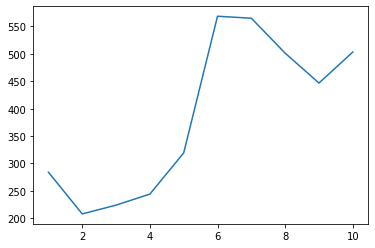

In [ ]:
plt.plot(np.arange(10)+1,loss_history)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model123.pkl')

In [ ]:
aa = model.load_state_dict(torch.load('model1.pkl'))

In [ ]:
np.save('w2v.npy', np.array(w2v))

In [ ]:
!ls

adc.json     sample_data  train_x.csv  w2v.npy
predict.csv  test_x.csv   train_y.csv
